# AlphaZero version 7

This AlphaZero version uses the custom and flexible `ValueLayer` to create the value output.
The model was trained from scratch on 1.000.000 training examples from the StageThree dataset on a 5x4 board. The model was trained for 16 epochs.

8 res-blocks instead of 4

128 filters instead of 64 

In [1]:
import sys
sys.path.append('..')

import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.initializers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
import keras.backend as K
from keras.regularizers import l2
from keras.engine.topology import Layer

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random
import gc

from LineFilterLayer import LineFilterLayer
from ValueLayer import ValueLayer

modelPath = 'model/alphaZeroV7.h5'

datasetPath = 'StageThree-1000000-5x4-22:56-19_04_2018.npz'

Using TensorFlow backend.


In [2]:
print(K.image_data_format()) 
# expected output: channels_last

channels_last


In [3]:
def dotsAndBoxesToCategorical(inputData):
    inp = np.copy(inputData)
    inp[inp == 255] = 1 # Line - comes first so that target data only has two categories
    inp[inp == 65] = 2 # Box A
    inp[inp == 150] = 3 # Box B
    inp[inp == 215] = 4 # Dot
    cat = to_categorical(inp)
    newShape = inp.shape + (cat.shape[-1],)
    return cat.reshape(newShape)

In [4]:
def imgSizeToBoxes(x):
    return (x-3)/2

def lineFilterMatrixNP(imgWidth,imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=np.bool)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = 1
    return mat


In [5]:
def loadPVDataset(datasetPath):
    rawDataset = np.load(datasetPath)
    
    x_input = rawDataset['input']
    y_policy = rawDataset['policy']
    y_value = rawDataset['value']
    
    x_input = dotsAndBoxesToCategorical(x_input)
    y_policy = y_policy[:,lineFilterMatrixNP(y_policy.shape[-1], y_policy.shape[-2])]
    y_policy /= 255
    
    return (x_input, y_policy, y_value)

np.set_printoptions(precision=2)
(x_input, y_policy, y_value) = loadPVDataset(datasetPath)

In [6]:
print(x_input.shape)
print(y_policy.shape)
print(y_value.shape)
print("input:")
print(x_input[0,::,::,1])
print("policy:")
print(y_policy[0])
print('value:')
print(y_value[0])

(1000000, 11, 13, 5)
(1000000, 49)
(1000000, 1)
input:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
policy:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
value:
[-0.88]


In [7]:
kernelSize = (5,5)
filterCnt = 128
l2reg = 1e-4
resBlockCnt = 8
imgWidth = x_input.shape[-2]
imgHeight = x_input.shape[-3]

def build_residual_block(x, index):
        in_x = x
        res_name = "res"+str(index)
        x = Conv2D(filters=filterCnt, kernel_size=kernelSize, padding="same",
                   data_format="channels_last", kernel_regularizer=l2(l2reg), 
                   name=res_name+"_conv1_"+str(filterCnt))(x)
        x = BatchNormalization(name=res_name+"_batchnorm1")(x)
        x = Activation("relu",name=res_name+"_relu1")(x)
        x = Conv2D(filters=filterCnt, kernel_size=kernelSize, padding="same",
                   data_format="channels_last", kernel_regularizer=l2(l2reg), 
                   name=res_name+"_conv2-"+str(filterCnt))(x)
        x = BatchNormalization(name="res"+str(index)+"_batchnorm2")(x)
        x = Add(name=res_name+"_add")([in_x, x])
        x = Activation("relu", name=res_name+"_relu2")(x)
        return x


img_input = Input(shape=(None,None,5,))
x = Conv2D(filterCnt, kernelSize, padding='same', kernel_regularizer=l2(l2reg), name="input_conv")(img_input)
x = Activation("relu", name="input_relu")(x)
x = BatchNormalization()(x)

for i in range(resBlockCnt):
    x = build_residual_block(x, i+1)

res_out = x

# policy output
x = Conv2D(1, kernelSize, padding='same', kernel_regularizer=l2(l2reg), name="policy_conv")(x)
x = LineFilterLayer(imgWidth, imgHeight)(x)
x = Activation("softmax", name="policy")(x)
policy_output = x

# value output
x = Conv2D(1, kernelSize, padding='same', kernel_regularizer=l2(l2reg), name="value_conv")(res_out)
#x = Flatten()(x)
#x = Dense(1, trainable=False, kernel_initializer=Constant(1.0/(imgWidth*imgHeight)), use_bias=False, name="value_dense")(x)
x = ValueLayer(imgWidth, imgHeight)(x)
x = Activation("tanh", name="value")(x)
value_output = x
    
model = Model(inputs=img_input, outputs=[policy_output, value_output])
model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mean_squared_error'])

#for layer in model.layers:
#    print("{:30}: {}".format(layer.name, layer.output_shape))
#    if layer.name is 'value_dense':
#        print(layer.kernel)
    
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 5 0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, None, None, 1 16128       input_1[0][0]                    
__________________________________________________________________________________________________
input_relu (Activation)         (None, None, None, 1 0           input_conv[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 512         input_relu[0][0]                 
__________________________________________________________________________________________________
res1_conv1

In [8]:
#sess = K.get_session()
#sess = tf_debug.LocalCLIDebugWrapperSession(sess)
#K.set_session(sess)

# Training
callbacks = []

checkpoint = ModelCheckpoint(filepath=modelPath+".checkpoint", save_weights_only=False)
callbacks.append(checkpoint)

progbar = ProgbarLogger()
callbacks.append(progbar)

tensorboard = TensorBoard(log_dir='model/log2', write_grads=True, write_graph=True, write_images=True, histogram_freq=1)
#callbacks.append(tensorboard)

model.fit(x_input, [y_policy, y_value], epochs=16, batch_size=64, callbacks=callbacks, validation_split=0.001)

model.save(modelPath)

Train on 999000 samples, validate on 1000 samples
Epoch 1/16
Epoch 1/16
999000/999000 [==============================] - 2834s 3ms/step - loss: 1.5254 - policy_loss: 1.1443 - value_loss: 0.2398 - val_loss: 1.3119 - val_policy_loss: 1.0191 - val_value_loss: 0.2067
Epoch 2/16
Epoch 2/16
999000/999000 [==============================] - 2775s 3ms/step - loss: 1.3106 - policy_loss: 1.0249 - value_loss: 0.2082 - val_loss: 1.2519 - val_policy_loss: 0.9864 - val_value_loss: 0.1989
Epoch 3/16
Epoch 3/16
999000/999000 [==============================] - 2785s 3ms/step - loss: 1.2435 - policy_loss: 1.0023 - value_loss: 0.1879 - val_loss: 1.2035 - val_policy_loss: 0.9730 - val_value_loss: 0.1818
Epoch 4/16
Epoch 4/16
999000/999000 [==============================] - 2747s 3ms/step - loss: 1.2231 - policy_loss: 0.9952 - value_loss: 0.1807 - val_loss: 1.1920 - val_policy_loss: 0.9624 - val_value_loss: 0.1836
Epoch 5/16
Epoch 5/16
999000/999000 [==============================] - 2739s 3ms/step - loss: 

In [9]:
def linesToDotsAndBoxesImage(lines, imgWidth, imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=lines.dtype)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = lines[idx]
    return mat

example: 266188
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 100   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]]
1.0
input (11, 13): 
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 1 0 1 0 0]
 [0 1 0 1 0 0 0 1 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 1 0 1 0]
 [0 0 0 0 1 0 1 0 0 0 1 0 0]
 [0 0 0 1 0 1 0 0 0 1 0 1 0]
 [0 0 1 0 1 0 0 0 1 0 1 0 0]
 [0 1 0 1 0 1 0 0 0 0 0 1 0]
 [0 0 1 0 1 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]
prediction policy: 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 100   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 

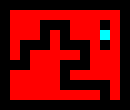

In [10]:
example = random.randrange(x_input.shape[0])
print("example: "+str(example))

input_data = x_input[example:example+1]

(prediction_lines, prediction_value) = model.predict(input_data)
prediction_lines_print = prediction_lines * 100
print(prediction_lines_print.astype(np.uint8))
print(np.sum(prediction_lines))
prediction = linesToDotsAndBoxesImage(prediction_lines[0], imgWidth, imgHeight)

# print input data
input_data_print = x_input[example,:,:,1] 
input_data_print = input_data_print.astype(np.uint8)
print("input "+str(input_data_print.shape)+": ")
print(input_data_print)

# generate greyscale image data from input data
planes = [1,2,3,4]
input_imgdata = np.sum(x_input[example,:,:,1:], axis=-1) * 255
input_imgdata = input_imgdata.astype(np.uint8)

# print prediction
prediction_data_print = prediction * 100 
prediction_data_print = prediction_data_print.astype(np.uint8)
print("prediction policy: ")
print(prediction_data_print)

print("prediction value: ")
print(prediction_value)

print("target value: ")
print(y_value[example])

# generate greyscale image data from prediction data
prediction_imgdata = prediction * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# generate greyscale image of target data
target_imgdata = linesToDotsAndBoxesImage(y_policy[example], imgWidth, imgHeight) * 255

# merge image data in color channels
merged_imgdata = np.stack([input_imgdata, prediction_imgdata, target_imgdata], axis=2)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img